# End-to-end notebook!

Here is the workflow:
* Sampling configs (sampling parameters, etc.) lead to...
* Weaving configs (blank model settings, donor model settings, layer assignments) lead to...
* Models (probably TFRobertaForSequenceClassification in all cases) lead to...
* Performance scores (numbers from 0-100)

In [1]:
# install dependencies

! pip install -q joblib  # joblib for memoizing functions
! pip install -q ipywidgets widgetsnbextension pandas-profiling # IProgress for progress bars

zsh:1: /home/brian/2023-fall-cs-194-294-merging-llms/.venv/bin/pip: bad interpreter: .venv/bin/python3.8: no such file or directory
zsh:1: /home/brian/2023-fall-cs-194-294-merging-llms/.venv/bin/pip: bad interpreter: .venv/bin/python3.8: no such file or directory


In [2]:
# Add model_merging to the python path

import os
import sys

model_merging_base = os.path.abspath("../model_merging/")
# assert it exist
assert os.path.exists(model_merging_base)
if model_merging_base not in sys.path:
    sys.path.append(model_merging_base)

In [3]:
# import joblib for caching and distributed computing
from math import sqrt

from joblib import Memory, Parallel, delayed

memory = Memory(location="cache", verbose=10)

parallel = Parallel(n_jobs=2, return_as="generator")
output_generator = parallel(delayed(sqrt)(i**2) for i in range(10))

In [4]:
# Imports and cached functions

import os

from llm_weaver import (
    calculate_score_from_weaving_config,
    test_weaver,
)

# Disable parallelism in tokenizers to avoid deadlocks
os.environ["TOKENIZERS_PARALLELISM"] = "false"

calculate_score_from_weaving_config_cached = memory.cache(
    calculate_score_from_weaving_config
)
test_weaver_cached = memory.cache(test_weaver)

2023-11-28 00:02:47.275671: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 00:02:47.309920: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 00:02:47.310516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 00:02:47.857276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Step 0: Test weaving code

This test makes sure that our score when using the weaver to reconstruct a model from all its parts get the same evaluation score as the original model

## Steps: configs to graph


In [5]:
from llm_weaver import dict_overwrite, get_model_config, normalize_glue_task_name


def transitions_weave_configs_iter(model_id, trajectories=None, max_configs=None):
    num_original_layers = get_model_config(model_id)["num_hidden_layers"]

    if trajectories is None:
        x_y_layer_sequences = [
            (x, y, (list(range(0, x + 1)) + list(range(y, num_original_layers))))
            for x in range(num_original_layers)
            for y in range(num_original_layers)
        ]
    else:
        x_y_layer_sequences = [(None, None, trajectory) for trajectory in trajectories]

    if max_configs is not None:
        x_y_layer_sequences = x_y_layer_sequences[:max_configs]
    for x, y, layer_sequence in x_y_layer_sequences:
        layer_assignments = [
            {
                "type": "SingleLayer",
                "params": {
                    "donor": model_id,
                    "hidden_layer_number": i,
                },
            }
            for i in layer_sequence
        ]

        blank_model_config = dict_overwrite(
            get_model_config("textattack/roberta-base-RTE"),
            {
                "num_hidden_layers": len(layer_assignments),
            },
        )
        config = {
            "glue_task": normalize_glue_task_name(model_id),
            "tokenizer_model_id": model_id,
            "blank_model_config": blank_model_config,
            "layer_assignments": layer_assignments,
            "classification_head": {
                "type": "SingleClassificationHead",
                "params": {
                    "donor": model_id,
                },
            },
            "embeddings": {
                "type": "SingleEmbeddings",
                "params": {
                    "donor": model_id,
                },
            },
            "metadata": {
                "x": x,
                "y": y,
            },
        }

        yield config


weave_configs = list(
    transitions_weave_configs_iter(
        model_id="textAttack/roberta-base-RTE",
    )
)


len(weave_configs)

2023-11-28 00:02:50.874814: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 00:02:50.875582: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, 

144

In [6]:
scores = Parallel(n_jobs=5, return_as="list")(
    delayed(calculate_score_from_weaving_config_cached)(
        weave_config,
        # n_examples=4096,
        n_examples=128,
        split="validation",
    )
    for weave_config in weave_configs
)
accuracies = [score["accuracy"] for score in scores]

2023-11-28 00:02:54.274956: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 00:02:54.297033: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 00:02:54.307353: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 00:02:54.307805: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 00:02:54.321428: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 00:02:54.329591: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-

[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/3d51a182fc1931e7eec3d04f30e6572d
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/cf4b6a1b9e71b5f51f8ab34d5b66a2fa
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/c5b35f168b5978c9a0ed688659548f46
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/0baf3de314cde2a3fbb133e15caaa937
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
[Memory]: Loading calculate_score_from_weaving_config from cache/job

<Axes: xlabel='y', ylabel='x'>

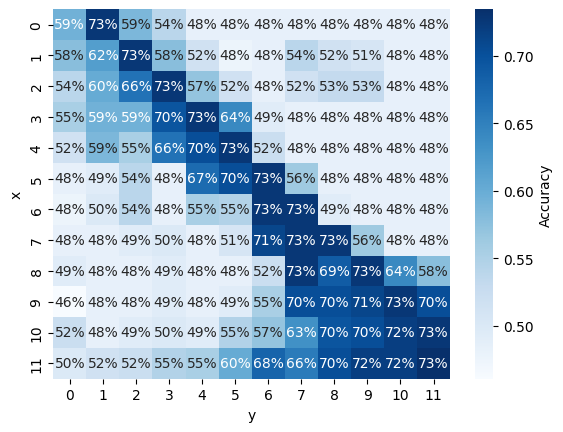

In [7]:
import pandas as pd

records = []
for weave_config, accuracy in zip(weave_configs, accuracies):
    record = weave_config["metadata"]
    record["accuracy"] = accuracy
    records.append(record)
df = pd.DataFrame.from_records(records)
df

# Plot a heatmap of the accuracy with respect to the layer transitions
# x and y are the layer numbers of the first and last layer of the transition
# the color is the accuracy

import seaborn as sns

sns.heatmap(
    df.pivot(index="x", columns="y", values="accuracy"),
    annot=True,
    fmt=".0%",
    cmap="Blues",
    cbar_kws={"label": "Accuracy"},
)

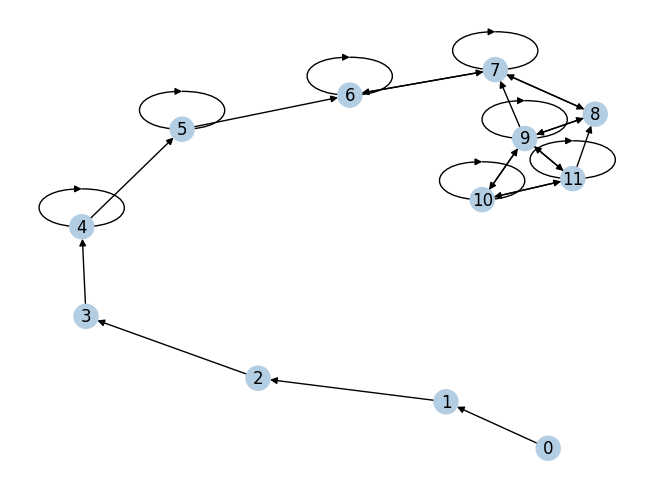

In [8]:
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(range(12))

weights = df.pivot(index="x", columns="y", values="accuracy").fillna(0).to_numpy()


for x in range(12):
    for y in range(12):
        # if the weight is > 0.7, add the edge
        if weights[x][y] > 0.7:
            G.add_edge(x, y, weight=weights[x][y])

# light blue nodes
node_colors = ["#b3cde3"] * 12
nx.draw(G, with_labels=True, node_color=node_colors)

In [9]:
# Sample trajectories
import random

random.seed(42)

trajectories_by_length = {}
for length in [11, 12, 13, 14, 15, 16, 17, 18]:
    trajectories = []
    while len(trajectories) < 5:
        trajectory = [0]
        while trajectory[-1] != 11:
            # Assume uniform distribution over neighbors
            trajectory.append(random.choice(list(G.neighbors(trajectory[-1]))))
        if len(trajectory) == length:
            trajectories.append(trajectory)
    trajectories_by_length[length] = trajectories

print(trajectories_by_length)

{11: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]], 12: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [0, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 11], [0, 1, 2, 3, 4, 5, 5, 6, 7, 8, 9, 11], [0, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 11], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 11]], 13: [[0, 1, 2, 3, 4, 5, 5, 6, 6, 7, 8, 9, 11], [0, 1, 2, 3, 4, 4, 5, 6, 7, 7, 8, 9, 11], [0, 1, 2, 3, 4, 4, 5, 5, 6, 7, 8, 9, 11], [0, 1, 2, 3, 4, 4, 4, 5, 6, 7, 8, 9, 11], [0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 8, 9, 11]], 14: [[0, 1, 2, 3, 4, 4, 5, 6, 6, 7, 8, 9, 10, 11], [0, 1, 2, 3, 4, 5, 6, 6, 6, 6, 7, 8, 9, 11], [0, 1, 2, 3, 4, 4, 5, 5, 6, 7, 8, 9, 9, 11], [0, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 8, 9, 11], [0, 1, 2, 3, 4, 5, 6, 6, 7, 7, 7, 8, 9, 11]], 15: [[0, 1, 2, 3, 4, 5, 5, 5, 6, 6, 6, 7, 8, 9, 11], [0, 1, 2, 3, 4, 5, 6, 7, 6, 6, 6, 7, 8, 9, 11], [0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 8, 9, 8, 9, 11], [0, 1, 2, 3, 4

In [10]:
records = []

for length, trajectories in trajectories_by_length.items():
    print(f"Length {length}")
    weave_configs = list(
        transitions_weave_configs_iter(
            "textAttack/roberta-base-RTE", trajectories=trajectories
        )
    )

    scores = Parallel(n_jobs=5, return_as="list")(
        delayed(calculate_score_from_weaving_config_cached)(
            weave_config,
            # n_examples=4096,
            n_examples=128,
            split="validation",
        )
        for weave_config in weave_configs
    )
    accuracies = [score["accuracy"] for score in scores]

    for trajectory, accuracy in zip(trajectories, accuracies):
        record = {}
        record["trajectory"] = trajectory
        record["accuracy"] = accuracy
        record["trajectory_length"] = len(trajectory)
        records.append(record)
df = pd.DataFrame.from_records(records)
df

Length 11
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/1c157a6909ec40cd39150f740d60f4c2
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/1c157a6909ec40cd39150f740d60f4c2
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/1c157a6909ec40cd39150f740d60f4c2
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/1c157a6909ec40cd39150f740d60f4c2
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
[Memory]: Loading calculate_score_from_weaving_config from

,trajectory,accuracy,trajectory_length
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]",0.703125,11
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]",0.703125,11
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]",0.703125,11
3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]",0.703125,11
4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]",0.703125,11
5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",0.726562,12
6,"[0, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 11]",0.718750,12
7,"[0, 1, 2, 3, 4, 5, 5, 6, 7, 8, 9, 11]",0.640625,12
8,"[0, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 11]",0.718750,12
9,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 11]",0.718750,12


<Axes: xlabel='trajectory_length', ylabel='accuracy'>

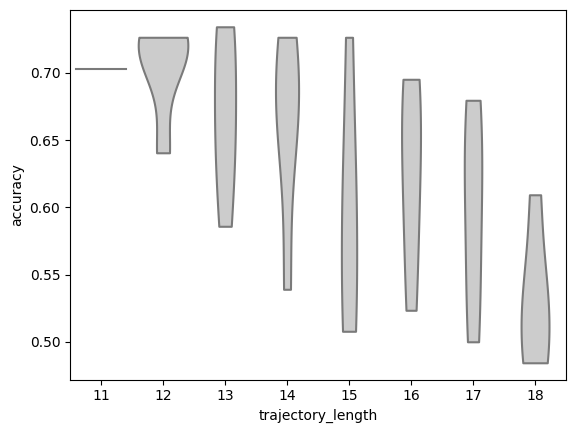

In [11]:
# Show a violin plot of the distribution of accuracies for each trajectory length
sns.violinplot(
    data=df,
    x="trajectory_length",
    y="accuracy",
    inner=None,
    color=".8",
    cut=0,
)